In [1]:
library(tidyverse)
library(caret)
library(MASS)
library(pROC)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




In [2]:
DatasetPath <- "./train.csv"
mysubset <- read.csv(DatasetPath)

In [3]:
# split dataset into training and holdout
splitDataset <- function (dataset, holdoutRatio) {
    count <- nrow(dataset); trainingIndex <- sample(count, count * (1 - holdoutRatio))
    list(training = dataset[trainingIndex,], holdout = dataset[-trainingIndex,])
}

In [4]:
# classification table
classificationTable <- function (actual, prediction) {
    a <- table(predictedValue = prediction, actualValue = actual)
    print(a)
    print(a[1, 2] + a[2, 1])
}

In [5]:
augmentRightTurn <- function(dataset) {
    isRightTurn <- function(entry, exit) {
        rightexit <- list(
            N = c("NW", "W", "SW"),
            NW = c("W", "SW", "S"),
            W = c("SW", "S", "SE"),
            SW = c("S", "SE", "E"),
            S = c("SE", "E", "NE"),
            SE = c("E", "NE", "N"),
            E = c("NE", "N", "NW"),
            NE = c("N", "NW", "W")
        )
        exit %in% rightexit[[entry]]
    }
    vIsRightTurn <- Vectorize(isRightTurn)
    t <- dataset %>% 
        mutate(RightTurn = vIsRightTurn(EntryHeading, ExitHeading)) %>%
        group_by(IntersectionId, EntryHeading) %>%
        summarize(RightTurnAllowed = max(RightTurn)) %>%
        inner_join(dataset)
    t %>% mutate(RightTurn = vIsRightTurn(EntryHeading, ExitHeading))
}

In [6]:
augmentLeftTurn <- function(dataset) {
    isLeftTurn <- function(entry, exit) {
        leftexit <- list(
            N = c("NE", "E", "SE"),
            NW = c("N", "NE", "E"),
            W = c("NW", "N", "NE"),
            SW = c("W", "NW", "N"),
            S = c("SW", "W", "NW"),
            SE = c("S", "SW", "W"),
            E = c("SE", "S", "SW"),
            NE = c("E", "SE", "S")
        )
        exit %in% leftexit[[entry]]
    }
    vIsLeftTurn <- Vectorize(isLeftTurn)
    t <- dataset %>% 
        mutate(LeftTurn = vIsLeftTurn(EntryHeading, ExitHeading)) %>%
        group_by(IntersectionId, EntryHeading) %>%
        summarize(LeftTurnAllowed = max(LeftTurn)) %>%
        inner_join(dataset)
    t %>% mutate(LeftTurn = vIsLeftTurn(EntryHeading, ExitHeading))
}

In [7]:
intervalScore=function(predObj,actual,alpha) { 
    n=nrow(predObj)
    ilow=(actual<predObj[,2]) # underestimation
    ihigh=(actual>predObj[,3]) # overestimation
    sumlength=sum(predObj[,3]-predObj[,2]) # sum of lengths of prediction intervals
    sumlow=sum(predObj[ilow,2]-actual[ilow])*2/alpha
    sumhigh=sum(actual[ihigh]-predObj[ihigh,3])*2/alpha
    avglength=sumlength/n
    IS=(sumlength+sumlow+sumhigh)/n # average length + average under/over penalties
    cover=mean(actual>= predObj[,2] & actual<=predObj[,3])
    summ=c(1-alpha,avglength,IS,cover)
    summ
}

In [8]:
RMSE <- function(predicted, expected, log=0) {
  if (log == 0){
      sqrt(mean((predicted - expected)^2))
  } else {
      temp <- which(predicted == 0)
      epred <- exp(predicted)
      epred[temp] <- 0
      sqrt(mean((epred- expected)^2)) 
  }
}

In [9]:
prepareDataset <- function (dataset) {
    # restrict analysis to Chicago
    r <- dataset %>% filter(City == 'Chicago')

    r <- augmentRightTurn(r)
    r <- augmentLeftTurn(r)
    r <- r %>% mutate(
        straightThrough = EntryHeading == ExitHeading,
        waitRequired = TotalTimeStopped_p50 > 0,
        rushHour = (Hour >= 6 & Hour <= 9) | (Hour >= 15 & Hour <= 18),
        logWaitTime = log(TotalTimeStopped_p50))
    r
}

In [10]:
oAugment <- prepareDataset(mysubset)

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")

`summarise()` regrouping output by 'IntersectionId' (override with `.groups` argument)

Joining, by = c("IntersectionId", "EntryHeading")



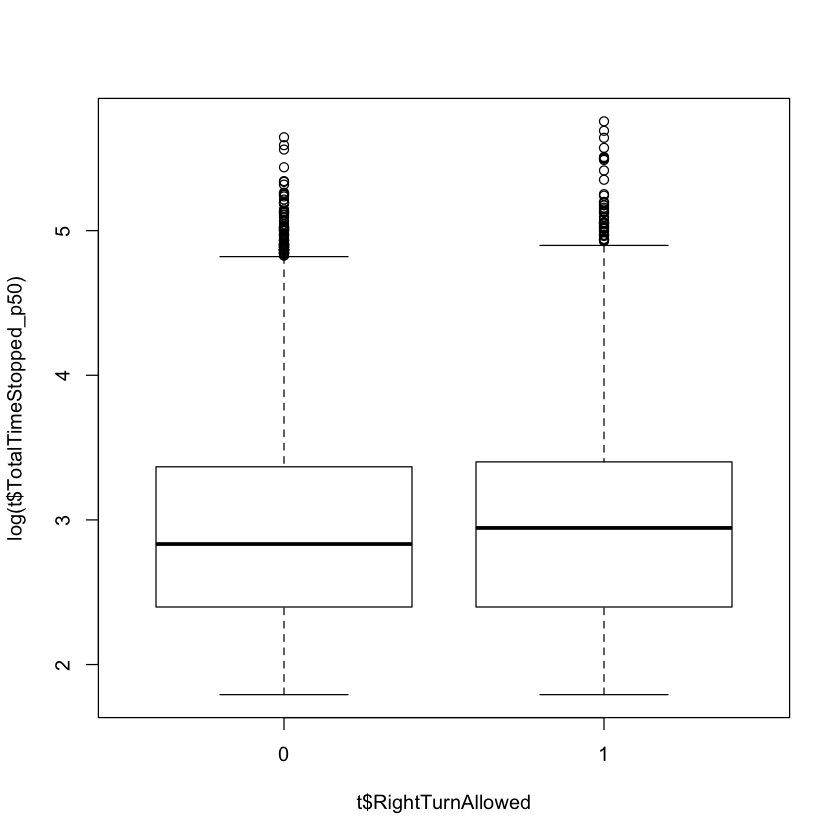

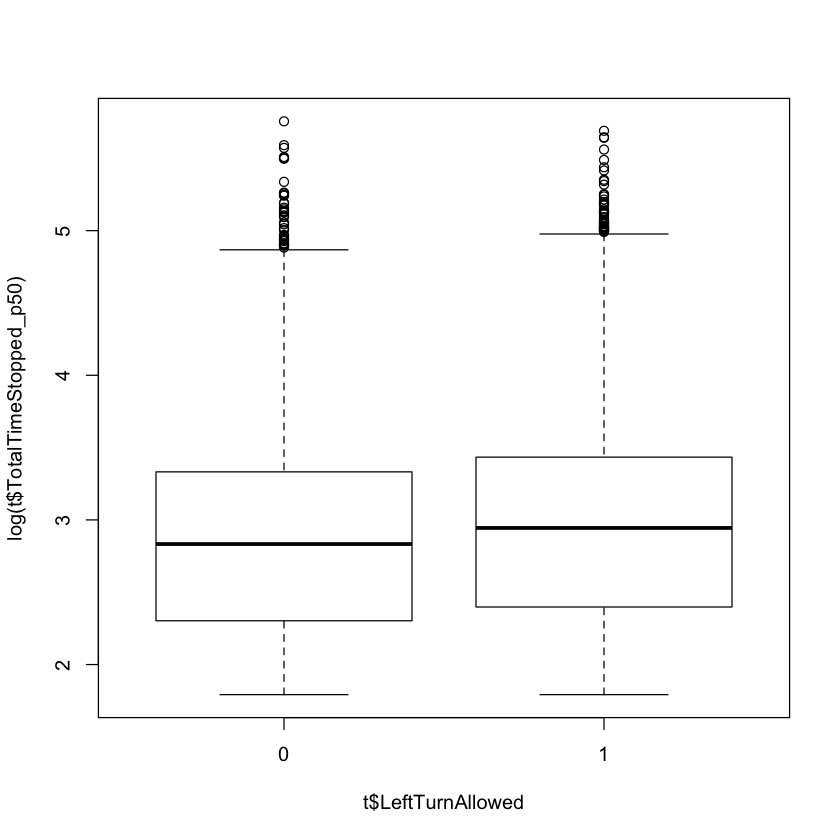

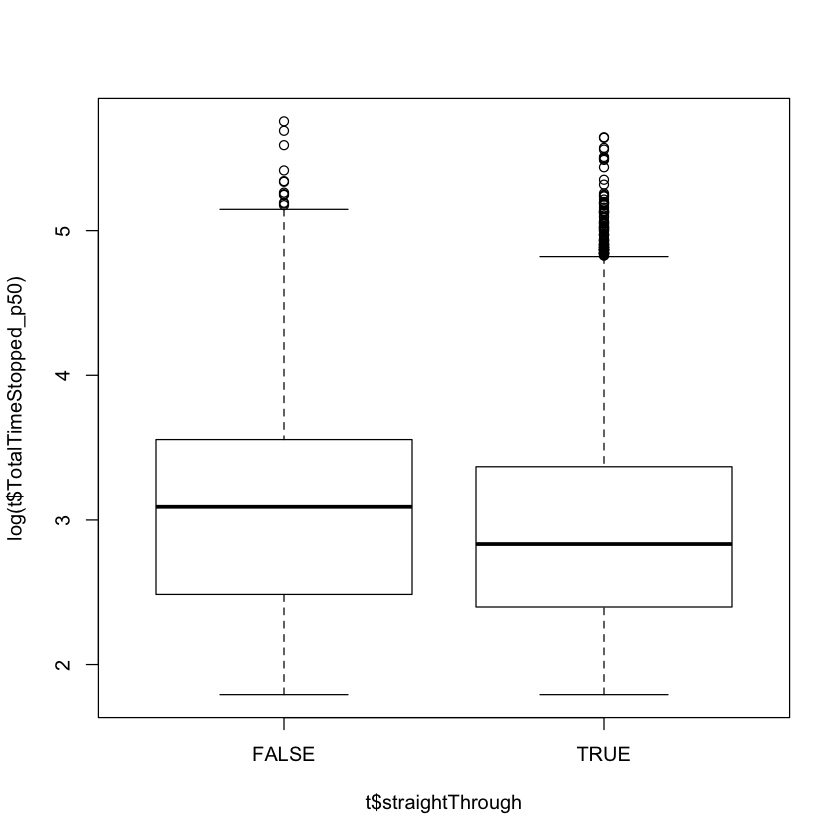

In [11]:
# box plots
t <- oAugment %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$RightTurnAllowed)

t <- oAugment %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$LeftTurnAllowed)

t <- oAugment %>% filter(TotalTimeStopped_p50 > 0)
boxplot(log(t$TotalTimeStopped_p50) ~ t$straightThrough)

In [12]:
# split dataset into training and holdout
workingDataset <- splitDataset(oAugment, 0.2)

In [13]:
# make sure holdout contains the same factors for column EntryStreetName as training
workingDataset$holdout <- workingDataset$holdout %>% filter(EntryStreetName %in% workingDataset$training$EntryStreetName)

In [14]:
ceq <- waitRequired ~ Hour + Month + rushHour + straightThrough + Weekend + LeftTurnAllowed + RightTurnAllowed + LeftTurn + RightTurn

quadratic <- lda(ceq, workingDataset$training)
probit <- glm(waitRequired ~ EntryStreetName + Hour + Month + rushHour + straightThrough + Weekend + LeftTurnAllowed + RightTurnAllowed + LeftTurn + RightTurn, family = binomial(link = "probit"), workingDataset$training)

In [15]:
pquadratic <- predict(quadratic, workingDataset$holdout)
pprobit <- 1 - predict(probit, workingDataset$holdout, type = "response")

In [21]:
classificationTable(workingDataset$holdout$waitRequired, pquadratic$posterior[,1] < 0.30)
classificationTable(workingDataset$holdout$waitRequired, pquadratic$posterior[,1] < 0.40)
classificationTable(workingDataset$holdout$waitRequired, pquadratic$posterior[,1] < 0.50)


classificationTable(workingDataset$holdout$waitRequired, pprobit < 0.20)
classificationTable(workingDataset$holdout$waitRequired, pprobit < 0.25)
classificationTable(workingDataset$holdout$waitRequired, pprobit < 0.30)
classificationTable(workingDataset$holdout$waitRequired, pprobit < 0.40)
classificationTable(workingDataset$holdout$waitRequired, pprobit < 0.50)

              actualValue
predictedValue FALSE  TRUE
         FALSE 18338  7845
         TRUE      2    11
[1] 7847
              actualValue
predictedValue FALSE  TRUE
         FALSE 18158  7552
         TRUE    182   304
[1] 7734
              actualValue
predictedValue FALSE  TRUE
         FALSE 17528  6839
         TRUE    812  1017
[1] 7651
              actualValue
predictedValue FALSE  TRUE
         FALSE 18319  7776
         TRUE     21    80
[1] 7797
              actualValue
predictedValue FALSE  TRUE
         FALSE 18299  7742
         TRUE     41   114
[1] 7783
              actualValue
predictedValue FALSE  TRUE
         FALSE 18269  7634
         TRUE     71   222
[1] 7705
              actualValue
predictedValue FALSE  TRUE
         FALSE 18044  7248
         TRUE    296   608
[1] 7544
              actualValue
predictedValue FALSE  TRUE
         FALSE 17382  6453
         TRUE    958  1403
[1] 7411


In [22]:
probitWithoutEntryStreet <- glm(ceq, family = binomial(link = "probit"), workingDataset$training)
pprobitWithoutEntryStreet <- 1 - predict(probitWithoutEntryStreet, workingDataset$holdout, type = "response")

Setting levels: control = FALSE, case = TRUE

Setting direction: controls > cases



Area under the curve: 0.6124

Setting levels: control = FALSE, case = TRUE

Setting direction: controls > cases



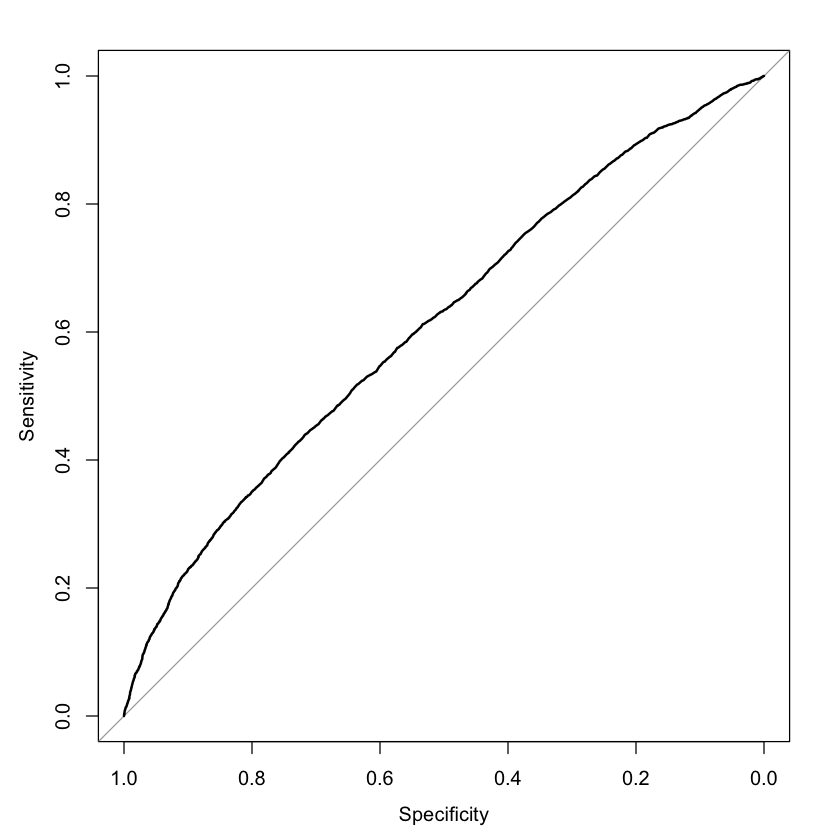

Area under the curve: 0.6715

Setting levels: control = FALSE, case = TRUE

Setting direction: controls > cases



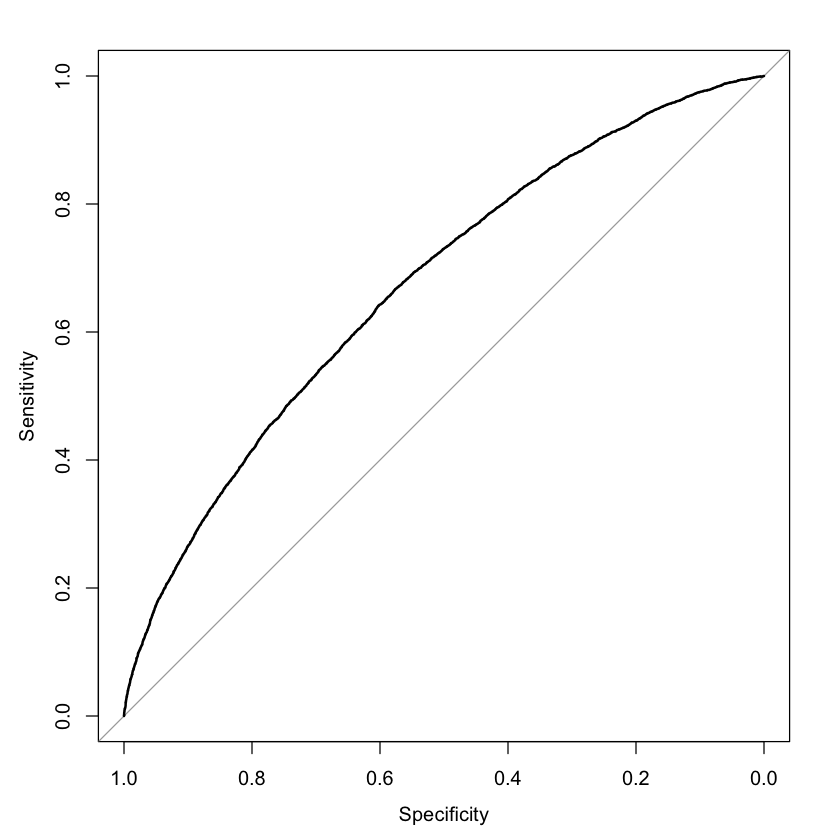

Area under the curve: 0.6129

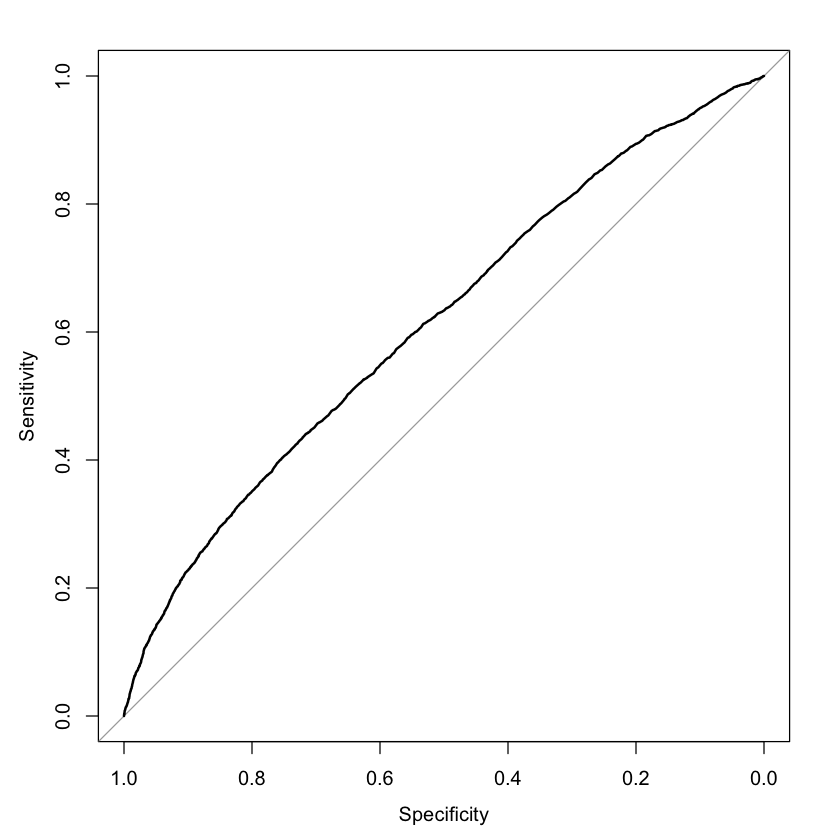

In [23]:
quadraticr <- roc(workingDataset$holdout$waitRequired, pquadratic$posterior[,1])
plot(quadraticr)
quadraticr$auc

probitr <- roc(workingDataset$holdout$waitRequired, pprobit)
plot(probitr)
probitr$auc

probitrWithoutStreet <- roc(workingDataset$holdout$waitRequired, pprobitWithoutEntryStreet)
plot(probitrWithoutStreet)
probitrWithoutStreet$auc

In [24]:
# prepare new training set
trainingGreaterThanZero <- workingDataset$training %>% filter(TimeFromFirstStop_p50 > 0)

In [25]:
# prepare new holdout set
workingDataset$holdout$classification <- pprobit > 0.25
holdoutGreaterThanZero <- workingDataset$holdout %>% filter(classification == 1)

In [26]:
eqref <- TotalTimeStopped_p50~Hour+rushHour+straightThrough+Weekend+LeftTurnAllowed+RightTurnAllowed+LeftTurn+RightTurn

In [27]:
lmobj <- lm(eqref, trainingGreaterThanZero)

In [28]:
lmprediction <- predict(lmobj, holdoutGreaterThanZero)

In [29]:
RMSE(lmprediction, holdoutGreaterThanZero$TotalTimeStopped_p50)

[1] 21.17104

In [30]:
outPredict1 <- predict(lmobj, newdata=holdoutGreaterThanZero, interval="prediction", level=0.5)
intervalScore(outPredict1, holdoutGreaterThanZero$TotalTimeStopped_p50,0.5)

[1]  0.5000000 24.6220690 56.6830888  0.1808686

In [31]:
outPredict1 <- predict(lmobj, newdata=holdoutGreaterThanZero, interval="prediction", level=0.8)
intervalScore(outPredict1, holdoutGreaterThanZero$TotalTimeStopped_p50,0.2)

[1]  0.8000000 46.7831273 56.1031649  0.7598403